# Praktyczny Machine Learning w Pythonie
<br>
<img src="figures/dilbert-2213.gif">

## Rozpoznawanie cyfr

Nasz model będzie składał się z 2 kroków:
1. Zmniejszenie ilości wymiarów
2. Klasyfikacja modelem liniowym

Najpierw jednak musimy zapoznać się ze zbiorem danych.

In [ ]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

### MNIST

<img src="figures/mnist_originals.png">

MNIST to baza danych odręcznie napisanych cyfr około 20 lat temu. Ludzie są w stanie rozpoznać ok. 99,5% cyfr z tego zbioru poprawnie.
Zobaczymy ile nam się uda!

In [ ]:
img = mnist.data[0]
print "Pierwsz obrazek z ", mnist.data.shape[0], ":", img # Pixele

In [ ]:
# Możemy sobie narysować wcześniej wypisaną cyfrę
import matplotlib.pylab as plt
%matplotlib inline
plt.imshow(img.reshape(28,28), cmap="gray")

In [ ]:
import sklearn
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import numpy as np

### Krok 1: wczytanie i podzielenie danych

Skalowanie jest bardzo ważne. Dzięki temu mamy średnią danej cechy 0 i wariancję 1 (mówiąc po ludzku, dane będą bardziej  przypominały kulke w przestrzeni wejściowej)

<img src="figures/prepro2.jpeg" width=600>

In [ ]:
#Wczytujemy dane i skalujemy
X, Y = mnist.data.astype("float64"), mnist.target 
X = preprocessing.scale(X)

Tak jak wspomniałem algorytm trenujemy na innych danych niż testujemy. **To bardzo ważne**. Do każdych danych da się dopasować taki model, który idealnie na nich odpowiada (np. poprzez zapamiętanie wszystkich przykładów). Jeśli tak zrobimy, to mówimy że nasz model **zoverfitował**.

<img src="figures/underfitting-overfitting.png">

In [ ]:
#Dzielimy na dane trenujące i testujące
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

### Krok 2: dopasujmy pare modeli - uwaga! To juz trwa chwile, 70000 przykladow o 784 cechach kazdy.

In [ ]:
# Na wszystkich przykladach osiaga 92% dokladnosci. 
N = 500 # Podzbiór danych
model = LogisticRegression() # Model z domyślnymi parametrami
model.fit(X_train[0:N], Y_train[0:N])

Y_test_predicted = model.predict(X_test)
print "Dokładność modelu wytrenowanego na ",N, " przykladach to: ",100*sklearn.metrics.accuracy_score(Y_test, Y_test_predicted), "%"

In [ ]:
Y_test[0]

In [ ]:
plt.imshow(model.coef_[3].reshape(28,28), cmap="gray")

In [ ]:
plt.imshow(model.coef_[0].reshape(28,28), cmap="gray")

In [ ]:
print "Przyklad zaklasyfikowany jako ", model.predict(X_test[0])
plt.imshow(X_test[0].reshape(28,28), cmap="gray")

### Krok 3: Tworzymy caly model zmniejszając ilość przykładów

W scikit-learn możemy połączyć pare modeli w **pipeline**, który sam implementuje interfejs **Estimator**.

In [ ]:
pca = decomposition.PCA(n_components=20)
pca.fit(X_train)
X_train_transf = pca.transform(X_train)

In [ ]:
logistic = linear_model.LogisticRegression(C=0.1)
logistic.fit(X_train_transf, Y_train)

Pipeline pozwala spinać obiekty typu `Estimator`. Za pomocą pipeline można tworzyć bardzo skomplikowane modele, które mają bardzo prosty interfejs

In [ ]:
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

In [ ]:
#Zobaczmy na dokładność modelu
Y_test_predicted = pipe.predict(X_test)
print "Dokładność modelu wytrenowanego to: ",100*sklearn.metrics.accuracy_score(Y_test, Y_test_predicted), "%"

**Poprawa o 6%! Nice**

### Poszukajmy najlepszych hiperparametrów

In [ ]:
from sklearn.grid_search import GridSearchCV

N = 200
tuned_parameters = [{'pca__n_components':[10,20,30], 'logistic__C':  [1, 10, 100, 1000]}]
clf_fitted = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
clf = GridSearchCV(clf_fitted, tuned_parameters, cv=5, scoring='accuracy', verbose=4)
clf.fit(X_train[0:N], Y_train[0:N])

In [ ]:
clf.best_estimator_

In [ ]:
#Zobaczmy na dokładność modelu
Y_test_predicted = clf.best_estimator_.predict(X_test)
print "Dokładność modelu wytrenowanego to: ",100*sklearn.metrics.accuracy_score(Y_test, Y_test_predicted), "%"

Dokładność jest mniejsza, ponieważ ograniczyliśmy sztucznie ilość przykładów. Spróbuj ją zwiększyć

## Podobna metodologia zadziała na trudniejszych zbiorach danych

In [ ]:
from sklearn.datasets import fetch_lfw_people

# Wczytanie danych i rozmiarow
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples, h, w = lfw_people.images.shape

# Podzial na zbior trenujacy i testujacy
X = lfw_people.data
Y = lfw_people.target
X = preprocessing.scale(X.astype("float64")) #scale() to preprocessing który normalizuje dane ze sa symetrycznie wokol 0
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)


plt.imshow(X_train[2].reshape(h,w), cmap=plt.cm.gray)
logistic = linear_model.LogisticRegression(C=1)
logistic.fit(X_train, Y_train)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
Y_test_predicted = logistic.predict(X_test)
print "Dokładność modelu wytrenowanego to: ",100*sklearn.metrics.accuracy_score(Y_test, Y_test_predicted), "%"

In [ ]:
n_samples, h, w

In [ ]:
## TODO: Dodatkowa sekcja?

# Deep Learning

Jak widać, na rozważanych zbiorach, można osiągnąć wysoką dokładność (>85%) używając prostych modeli. Niestety na bardziej skomplikowanych danych (np. CIFAR-100, https://www.cs.toronto.edu/~kriz/cifar.html) nie jest już tak prosto.

Tradycyjne architektury, które były popularne do niedawna, używały ręcznej ekstrakcji "lepszych" cech:

<img src="figures/standard.jpg">

Deep Learning jest poddziedziną machine learningu, gdzie rozważamy architektury, które samoistnie uczą się cech na tyle dobrych, że dokładnie takie same modele jak Państwu pokazywaliśmy działają z zadowalającą precyzją

<img src="figures/features.png">

## Sieci konwolucyjne,
### i co to ma wspólnego z AlphaGo?

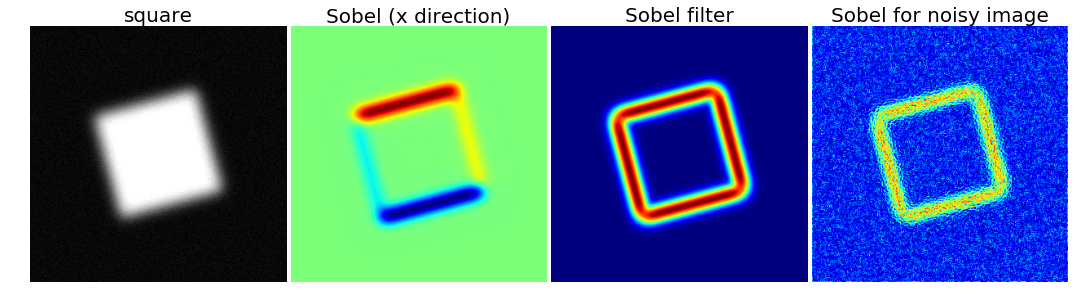

In [21]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

im = np.zeros((256, 256))
im[64:-64, 64:-64] = 1

im = ndimage.rotate(im, 15, mode='constant')
im = ndimage.gaussian_filter(im, 8)

sx = ndimage.sobel(im, axis=0, mode='constant')
sy = ndimage.sobel(im, axis=1, mode='constant')
sob = np.hypot(sx, sy)

plt.figure(figsize=(16, 5))
plt.subplot(141)
plt.imshow(im, cmap=plt.cm.gray)
plt.axis('off')
plt.title('square', fontsize=20)
plt.subplot(142)
plt.imshow(sx)
plt.axis('off')
plt.title('Sobel (x direction)', fontsize=20)
plt.subplot(143)
plt.imshow(sob)
plt.axis('off')
plt.title('Sobel filter', fontsize=20)

im += 0.07*np.random.random(im.shape)

sx = ndimage.sobel(im, axis=0, mode='constant')
sy = ndimage.sobel(im, axis=1, mode='constant')
sob = np.hypot(sx, sy)

plt.subplot(144)
plt.imshow(sob)
plt.axis('off')
plt.title('Sobel for noisy image', fontsize=20)



plt.subplots_adjust(wspace=0.02, hspace=0.02, top=1, bottom=0, left=0, right=0.9)

plt.show()

<img src="figures/cnn.jpg">
Jak może wyglądać taka architektura?

Zastanówmy się jakbyśmy wykrywali krawędź na obrazku? Można to zrealizować przez "przykładanie" macierzy

```
0 0 0
1 1 1
0 0 0
```

do obrazka w każdym miejscu, taką operację nazywamy konwolucją. W wyniku dostaniemy obrazek, gdzie aktywnością pixela jest jego zgodność (i jego otoczenia) z takim obrazkiem krawędzi (filtrem)